In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import random
from plots import *
from helpers import *
from boxes import *
%matplotlib inline

dataset has cars: 8792
none cars: 8968


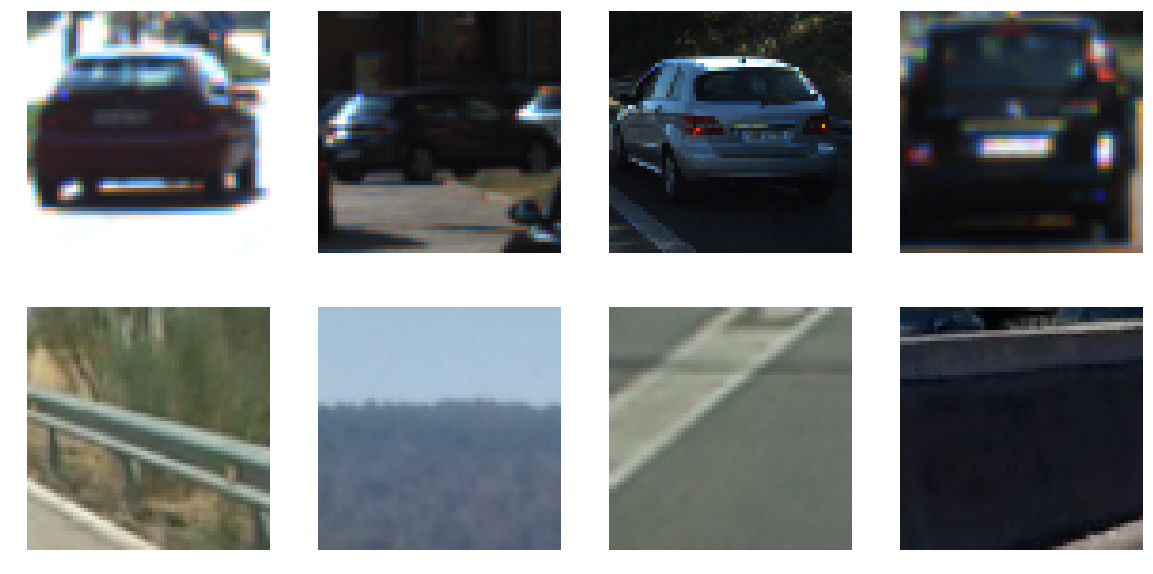

In [2]:
# loading project dataset
# car images and none car images

# get vehicles and non-vehicles images from here
# https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip
# https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip
# and extract into dataset directory
cars = glob.glob('datasets/vehicles/**/*.png', recursive=True)
notcars = glob.glob('datasets/non-vehicles/**/*.png', recursive=True)

# cloading car images
car_image = []
for impath in cars:
    car_image.append (mpimg.imread(impath))

# loading non car images
notcar_image = []
for impath in notcars:
    notcar_image.append (mpimg.imread(impath))

car_image_count = len (car_image)
notcar_image_count = len (notcar_image)

print ('dataset has cars:', car_image_count)
print ('none cars:', notcar_image_count)

# show dataset images examples
example_images = [
    car_image [random.randint (0, car_image_count-1)],
    car_image [random.randint (0, car_image_count-1)],
    car_image [random.randint (0, car_image_count-1)],
    car_image [random.randint (0, car_image_count-1)],
    
    notcar_image [random.randint (0, notcar_image_count-1)],
    notcar_image [random.randint (0, notcar_image_count-1)],
    notcar_image [random.randint (0, notcar_image_count-1)],
    notcar_image [random.randint (0, notcar_image_count-1)]
]

show_images_in_table (example_images, (4, 2), fig_size=(20, 10))

In [3]:
# parameters of feature extraction

color_space = 'GRAY' # Can be GRAY, RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off


C:\Users\nchokoev\AppData\Local\conda\conda\envs\carnd-term1-1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


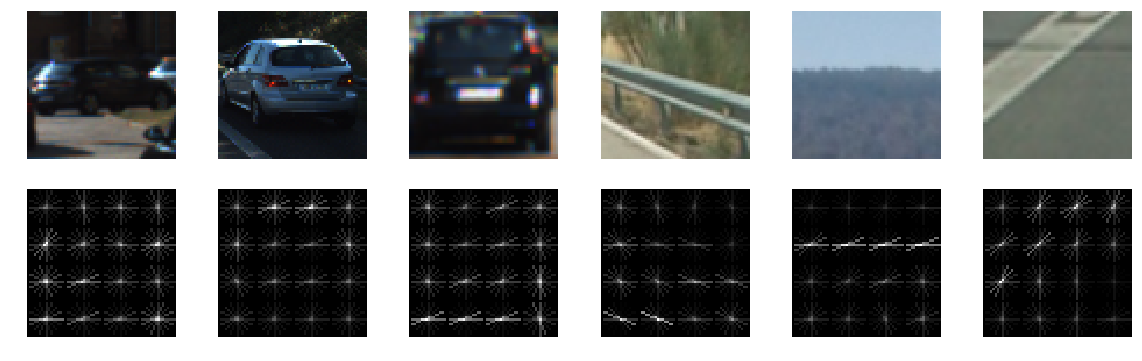

In [4]:
images_for_features = list (example_images [1:-1])

feature_examples = []
feature_examples.extend (images_for_features)

for im in images_for_features:
    features, hog_image = get_hog_features(get_s_from_hls(im), orient, pix_per_cell, cell_per_block, vis=True)
    feature_examples.append (hog_image)
    
show_images_in_table (feature_examples, (6, 2), fig_size=(20, 6))

In [5]:
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# combine original and autti datasets and extract features

# original dataset seems to have black cars bias
# so I use only 4000 car images and about 10K car images from autti
all_cars = []
all_cars.extend (car_image [:4000])

# I use bigger number of not car images
all_notcars = []
all_notcars.extend (notcar_image)

print ('result dataset:', len(all_cars), 'cars /', len(all_notcars), 'not cars')

ft=time.time()
car_features = extract_features(all_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(all_notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
ft2=time.time()
print ('features extraction time: ', round(ft2-ft, 2))

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

result dataset: 4000 cars / 8968 not cars


C:\Users\nchokoev\AppData\Local\conda\conda\envs\carnd-term1-1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


features extraction time:  16.85
Using: 8 orientations 16 pixels per cell and 1 cells per block
Feature vector length: 128


In [6]:
# I use default rbf kernel SVM
svc = SVC ()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Test Accuracy of SVC =  0.9892


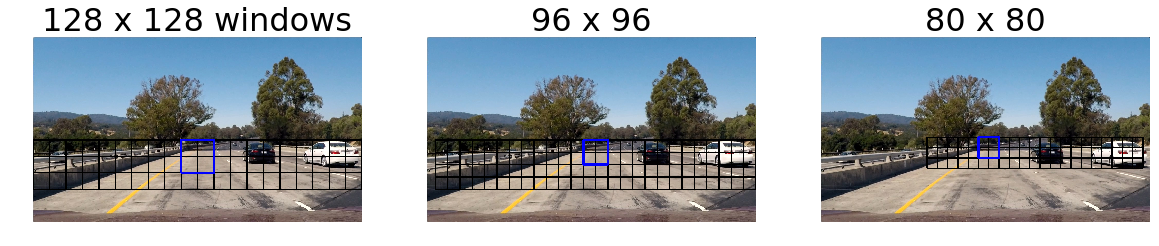

In [7]:
# defining parameters of sliding windows
# I use 3 sliding windows with different sizes, and different positions

image = mpimg.imread('test_images/test1.jpg')
window_img = np.copy(image)

sw_x_limits = [
    [None, None],
    [32, None],
    [412, 1280]
]

sw_y_limits = [
    [400, 640],
    [400, 600],
    [390, 540]
]

sw_window_size = [
    (128, 128),
    (96, 96),
    (80, 80)
]

sw_overlap = [
    (0.5, 0.5),
    (0.5, 0.5),
    (0.5, 0.5)
]

# create sliding windows
windows = slide_window(image, x_start_stop=sw_x_limits[0], y_start_stop=sw_y_limits[0], 
                    xy_window=sw_window_size[0], xy_overlap=sw_overlap[0])

windows2 = slide_window(image, x_start_stop=sw_x_limits[1], y_start_stop=sw_y_limits[1], 
                    xy_window=sw_window_size[1], xy_overlap=sw_overlap[1])

windows3 = slide_window(image, x_start_stop=sw_x_limits[2], y_start_stop=sw_y_limits[2], 
                    xy_window=sw_window_size[2], xy_overlap=sw_overlap[2])

# show sliding windows
sliding_windows = []
sliding_windows.append (draw_boxes(np.copy(image), windows, color=(0, 0, 0), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows2, color=(0, 0, 0), thick=4))
sliding_windows.append (draw_boxes(np.copy(image), windows3, color=(0, 0, 0), thick=4))

# drawing one of sliding windows in blue
sliding_windows [0] = draw_boxes (sliding_windows [0], [windows[9]], color=(0, 0, 255), thick=8)
sliding_windows [1] = draw_boxes (sliding_windows [1], [windows2[12]], color=(0, 0, 255), thick=8)
sliding_windows [2] = draw_boxes (sliding_windows [2], [windows3[5]], color=(0, 0, 255), thick=8)

sw_titles = [
    '128 x 128 windows',
    '96 x 96',
    '80 x 80'
]

show_images_in_table (sliding_windows, (3, 1), fig_size=(20, 14), titles=sw_titles)

C:\Users\nchokoev\AppData\Local\conda\conda\envs\carnd-term1-1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


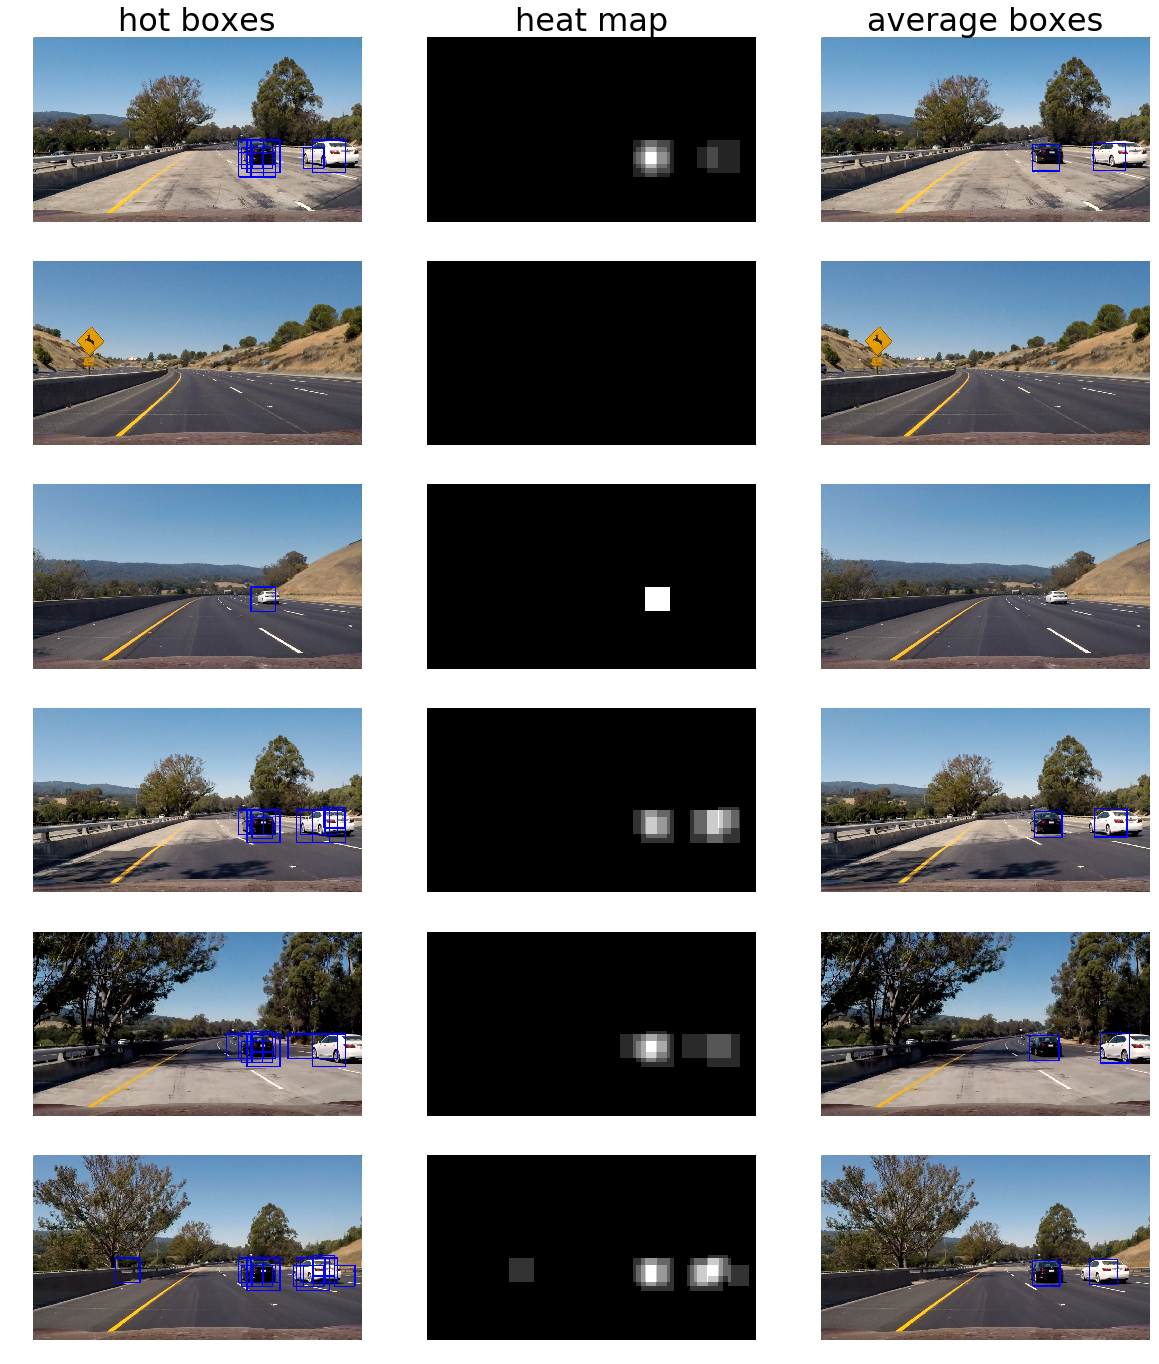

In [8]:
# algorithm demonstration on test images

test_images = []
test_images_titles = []

for impath in glob.glob('test_images/test*.jpg'):
    image_orig = mpimg.imread(impath)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image_orig.astype(np.float32)/255

    # hot boxes
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image, svc, X_scaler, sw_x_limits, sw_y_limits, sw_window_size, sw_overlap, color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
    # heat map
    heat_map = get_heat_map (image, hot_boxes)
    
    # average boxes
    avg_boxes = calc_average_boxes (hot_boxes, 2)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)
    
    test_images.append (image_with_hot_boxes)
    test_images.append (heat_map)
    test_images.append (image_with_boxes)
    
    test_images_titles.extend (['', '', ''])
    
test_images_titles [0] = 'hot boxes'
test_images_titles [1] = 'heat map'
test_images_titles [2] = 'average boxes'

show_images_in_table (test_images, (3, 6), fig_size=(20, 24), titles=test_images_titles)

In [9]:
# in video I use information from multiple frames to
# make average boxes more robust and filter false positives
# I accumulate all hot boxes from last several frames and use them
# for calculating average boxes



last_hot_boxes = LastHotBoxesQueue ()
    
def process_image (image_orig):
    
    image_orig = np.copy (image_orig)
    image = image_orig.astype(np.float32)/255
    
    # accumulating hot boxes over 10 last frames
    hot_boxes, image_with_hot_boxes = get_hot_boxes (image, svc, X_scaler, sw_x_limits, sw_y_limits, sw_window_size, sw_overlap, color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
    last_hot_boxes.put_hot_boxes (hot_boxes)
    hot_boxes = last_hot_boxes.get_hot_boxes ()
    
    # calculating average boxes and use strong ones
    # need to tune strength on particular classifer
    avg_boxes = calc_average_boxes (hot_boxes, 20)
    image_with_boxes = draw_boxes(image, avg_boxes, color=(0, 0, 1), thick=4)

    return image_with_boxes * 255

In [10]:
from moviepy.editor import VideoFileClip
# import imageio
# imageio.plugins.ffmpeg.download()

def process_video (input_path, output_path):
    clip = VideoFileClip (input_path)
    
    # uncomment to operate on individual frames
#     image = clip.get_frame(8./30)
#     r = process_image(image)
#     plt_show (r/255)

    result = clip.fl_image (process_image)
    %time result.write_videofile (output_path)

# select video to operate on
# process_video ('test_video.mp4', 'test_video_result.mp4')
process_video ('project_video.mp4', 'project_video_result.mp4')
# process_video ('challenge_video.mp4', 'challenge_video_result.mp4')
# process_video ('harder_challenge_video.mp4', 'harder_challenge_video_result.mp4')


[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing audio in project_video_resultTEMP_MPY_wvf_snd.mp3


100%|█████████████████████████████████████████████████████████████████████████████| 1112/1112 [00:01<00:00, 980.02it/s]


[MoviePy] Done.
[MoviePy] Writing video project_video_result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:01<00:00,  2.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

Wall time: 8min 3s
